Exploration of the MSZoning variable. It's description is, "Identifies the general zoning classification of the sale". Possible values are:
```
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM	Residential Medium Density
```

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

from helpers.sklearn_pieces import str_category_pipeline
from house_prices.helpers.column_categories import continuous_columns, categorical_unordered_columns, categorical_ordered_columns
from house_prices.helpers.utils import association_matrix, anova_with_effect_size, anova_matrix

sns.set(rc={'figure.figsize':(15,10)})

Let's load in the data and first zero in on the relationship between the variable and SalePrice

In [2]:
train = pd.read_csv('../data/train.csv', index_col=0).loc[:, ['MSZoning', 'SalePrice']]

In [3]:
print(train.shape)
print(train['MSZoning'].isnull().sum())

(1460, 2)
0


We have 1460 rows in the dataset and MSZoning has no null values. Let's look at the distribution of values.

In [4]:
train.MSZoning.value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

78.8% of homes are zoned as Residential Low Density. 14.9% are Residential Medium Density. This leaves 6.3% to split among the rest of the categories. Interestingly there are houses zoned as Floating Village Residential, and they represent 4.5% of that remaining 6.3%. As we're looking at data from Iowa, this is something to look into outside of the data to get a better understanding of the data. The fact that there are so few homes zoned as Residential High Density and Commerical mean we need to play close attention to the distributions of SalePrices within those variables.

In [13]:
median_saleprice_by_mszoning = train.groupby('MSZoning').median()['SalePrice'].sort_values()
print(median_saleprice_by_mszoning)
saleprice_ordering = median_saleprice_by_mszoning.index

MSZoning
C (all)     74700
RM         120500
RH         136500
RL         174000
FV         205950
Name: SalePrice, dtype: int64


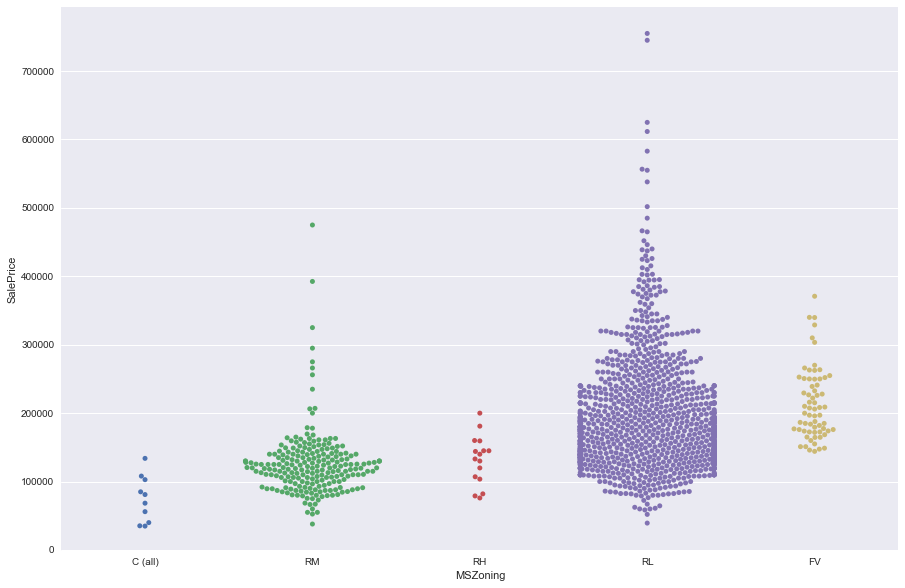

In [10]:
sns.swarmplot(x='MSZoning', y='SalePrice', order=saleprice_ordering, data=train);

The Floating Village homes have significantly higher prices. Perhaps the category is useful after all. I had assumed it would be the same as one of the other residential zonings. We can also happily see that the spreads of prices for both Residential High Density and Commerical are small meaning predictions using the median for this category will probably be decent. We do see long tails at the upper end of prices for both medium and low density houses. This is not surprising as there will always be those small number of expensive houses, and they will likely be in areas that have more land to fit the larger houses.

To me, there doesn't seem to be much more information we can get out of this variable. There are very few groups and they look to be significantly different enough in concept to preclude any combinations of the groups. So, let's see what a simple model using only this feature will get us!

In [11]:
test = pd.read_csv('../data/test.csv', index_col=0)

In [15]:
print(test.shape)
print(test['MSZoning'].isnull().sum())

(1459, 79)
4


In [12]:
test['MSZoning'].value_counts()

RL         1114
RM          242
FV           74
C (all)      15
RH           10
Name: MSZoning, dtype: int64

Fortunately, the distribution of zoning categories in the test dataset is extremely similar to that of the training dataset, and we have no new categories in the test set. Unfortunately, we have 4 houses without a zoning category. Since the vast majority of homes are zoned as Residential Low Density, let's assume that's what these are.

In [38]:
test.MSZoning = test.MSZoning.fillna('RL')

In [39]:
predictions = test['MSZoning'].map(median_saleprice_by_mszoning).values
submission = pd.DataFrame(columns=['Id', 'SalePrice'])
submission['Id'] = test.index
submission['SalePrice'] = predictions
submission.to_csv('mszoning_only.csv', index=False)

This model achieved a RMSE of 0.37988 which is not higher than the MSSubClass only median model. Similar to what we did with MSSubClass, let's stick this into a RandomForestRegressor and see if we do any better.

In [11]:
train = pd.read_csv('../data/train.csv', index_col=0)
train_X = train.drop("SalePrice", axis=1).copy()
train_y = train["SalePrice"].copy()
test = pd.read_csv('../data/test.csv', index_col=0).copy()

In [3]:
pipeline = str_category_pipeline('MSZoning', impute=True)

In [5]:
train_X_prep = pipeline.fit_transform(train_X)

In [9]:
params = {
    'max_depth': randint(2, 400),
    'min_samples_split': randint(2, 100),
}
rnd_clf = RandomForestRegressor(n_estimators=500)
forest_search = RandomizedSearchCV(rnd_clf, param_distributions=params, 
                                   n_iter=400, n_jobs=6, scoring='neg_mean_squared_log_error')
forest_search.fit(train_X_prep, train_y)
final_model = forest_search.best_estimator_

In [10]:
forest_search.best_params_

{'max_depth': 172, 'min_samples_split': 18}

We should round our predictions to the nearest integer as the sale prices are all integers.

In [16]:
test_prep = pipeline.fit_transform(test)
predictions = final_model.predict(test_prep).round()
submission_df = pd.DataFrame(
    data=predictions,
    index=test.index,
    columns=['SalePrice']
)
submission_df.to_csv('submission.csv')

This model did terribly with a RMSE of 0.51487. I wonder if the scoring metric is to blame. Let's go back to the default and try again.

In [17]:
params = {
    'max_depth': randint(2, 400),
    'min_samples_split': randint(2, 100),
}
rnd_clf = RandomForestRegressor(n_estimators=500)
forest_search = RandomizedSearchCV(rnd_clf, param_distributions=params, n_iter=400, n_jobs=6)
forest_search.fit(train_X_prep, train_y)
final_model = forest_search.best_estimator_

In [18]:
forest_search.best_params_

{'max_depth': 157, 'min_samples_split': 3}

In [19]:
predictions = final_model.predict(test_prep).round()
submission_df = pd.DataFrame(
    data=predictions,
    index=test.index,
    columns=['SalePrice']
)
submission_df.to_csv('submission.csv')

Pretty much the same score: 0.51460.

Now let's look out how MSZoning is associated with the other columns.

In [2]:
train = pd.read_csv('../data/train.csv', index_col=0)

In [3]:
association_matrix(train, 'MSZoning', categorical_unordered_columns)

Alley            0.717417
Neighborhood     0.640629
MSSubClass       0.337298
CentralAir       0.296601
Street           0.249384
GarageFinish     0.224655
Foundation       0.223617
GarageType       0.212814
BldgType         0.188501
Exterior2nd      0.186286
HouseStyle       0.184489
Exterior1st      0.177903
LotShape         0.152191
SaleType         0.150903
SaleCondition    0.136065
Electrical       0.103032
LandContour      0.102102
MasVnrType       0.099354
RoofStyle        0.072909
LandSlope        0.071793
Condition1       0.071332
LotConfig        0.063847
Condition2       0.058713
Heating          0.054550
MoSold           0.025137
RoofMatl         0.000000
Utilities        0.000000
MiscFeature      0.000000
MSZoning              NaN
dtype: float64

Two interesting high correlations here in Alley and Neighborhood. Let's take a look at the crosstabs.

In [4]:
pd.crosstab(train['MSZoning'], train['Alley'])

Alley,Grvl,Pave
MSZoning,,
C (all),0,2
FV,0,24
RH,0,2
RL,14,6
RM,36,7


In [5]:
train['Alley'].value_counts()

Grvl    50
Pave    41
Name: Alley, dtype: int64

Looks like the vast majority of houses don't have alleys, but if it does have an alley: gravel alleys are only present in medium and low density residential zones though some houses have paved alleys, floating village homes always have paved alleys. It may be interesting to see whether houses with alleys have higher prices than those without.

In [7]:
pd.crosstab(train['Neighborhood'], train['MSZoning'])

MSZoning,C (all),FV,RH,RL,RM
Neighborhood,,,,,
Blmngtn,0,0,0,16,1
Blueste,0,0,0,0,2
BrDale,0,0,0,0,16
BrkSide,0,0,0,28,30
ClearCr,0,0,0,28,0
CollgCr,0,0,0,140,10
Crawfor,0,0,2,46,3
Edwards,0,0,2,90,8
Gilbert,0,0,0,79,0


Almost all of the commercially zoned houses are in a single neighborhood. All floating village houses are in a single neighborhood. For low and medium density homes, neighborhoods tend to be primarily (and sometimes entirely) one or the other. It seems like Neighborhood may contain a lot of the MSZoning information.